## 1. import data and libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults 
from statsmodels.tsa.api import VAR


In [2]:
dr = pd.read_csv('stock_timeseries.csv')

In [7]:
df = dr
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2645 entries, 2020-12-30 to 2010-06-30
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  2645 non-null   int64         
 1   날짜          2645 non-null   object        
 2   apple       2645 non-null   float64       
 3   tesla       2645 non-null   float64       
 4   google      2645 non-null   float64       
 5   samsung     2571 non-null   float64       
 6   DATE        2645 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 165.3+ KB


## 2. EDA ##

In [8]:
# Change DATE type from Object to datetime #
df["DATE"] = pd.to_datetime(df["날짜"])
df.rename(columns = {"애플":"apple", "테슬라" : "tesla", "구글":"google", "삼성전자" : "samsung"}, inplace = True)

df.index = df['DATE']
df = df.drop(["Unnamed: 0","날짜","DATE","tesla","google"], axis = 1)
df["samsung"] = df["samsung"]/1100
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2645 entries, 2020-12-30 to 2010-06-30
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   apple    2645 non-null   float64
 1   samsung  2571 non-null   float64
dtypes: float64(2)
memory usage: 62.0 KB


In [15]:
print(df.isna().sum())
df = df.dropna(axis=0)

apple       0
samsung    74
dtype: int64


<AxesSubplot:xlabel='DATE'>

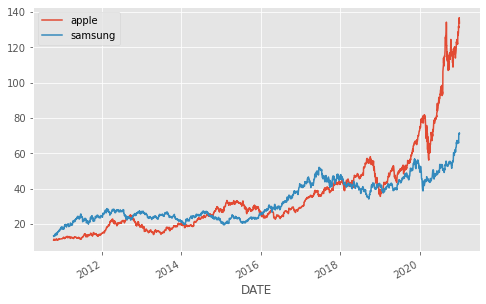

In [16]:
## View Data
df.plot(figsize = (8,5))

In [17]:
## 정상성 검정 ##
adfuller_test = adfuller(df['samsung'], autolag= "AIC")
print("SAMSUNG ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

adfuller_test1 = adfuller(df['apple'], autolag= "AIC")
print("APPLE ADF test statistic: {}".format(adfuller_test1[0]))
print("p-value: {}".format(adfuller_test[1]))

SAMSUNG ADF test statistic: -2.312654285681629
p-value: 0.167919187240754
APPLE ADF test statistic: -4.3669460206904125
p-value: 0.167919187240754


 - 모든변수 정상성 만든 후 var 세워야 함

## 3. 데이터 정상화 ##

In [18]:
df_diff = df.diff().dropna()

In [20]:
## 정상성 검정 ##
adfuller_test = adfuller(df_diff['samsung'], autolag= "AIC")
print("SAMSUNG ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

adfuller_test1 = adfuller(df_diff['apple'], autolag= "AIC")
print("APPLE ADF test statistic: {}".format(adfuller_test1[0]))
print("p-value: {}".format(adfuller_test[1]))\

SAMSUNG ADF test statistic: -11.81590319245638
p-value: 8.639684913753366e-22
APPLE ADF test statistic: -8.654877166094447
p-value: 8.639684913753366e-22


 - 차분 결과 Stationary

## 4. Build model ##

In [21]:
# Set Test & Train data
train = df_diff.iloc[:-20,:]
test = df_diff.iloc[-20:,:]

In [23]:
train

,apple,samsung
DATE,,
2020-12-29,1.15,0.363636
2020-12-28,1.82,-0.818182
2020-12-24,-4.72,0.000000
2020-12-23,-1.01,-3.545455
2020-12-22,0.92,-1.454545
...,...,...
2010-11-17,-0.29,-0.545455
2010-11-16,0.04,-0.054545
2010-11-15,0.20,-0.527273


In [31]:
## var model 최적의 p 찾기 ##
forecasting_model = VAR(train)
results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.



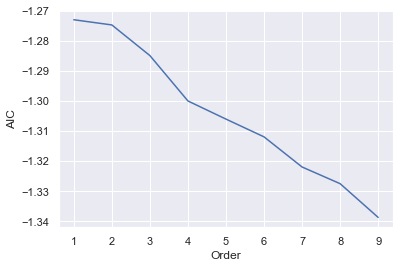

In [32]:
## p값별로 aic 보기 ##
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

 - aic가 계속 내려감, 그러나 이론상 비논리적이므로 해석 용이성을 위해 p는 3으로 설정

## 5. Model 해석 ##

In [36]:
# 모델 결과 보기 #
results = forecasting_model.fit(3)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 30, Nov, 2021
Time:                     21:53:25
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.25285
Nobs:                     2547.00    HQIC:                  -1.27332
Log likelihood:          -5577.67    FPE:                   0.276660
AIC:                     -1.28497    Det(Omega_mle):        0.275145
--------------------------------------------------------------------
Results for equation apple
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             -0.052185         0.018631           -2.801           0.005
L1.apple          -0.120130         0.019720           -6.092           0.000
L1.samsung         0.058166         0.033004            1.762           

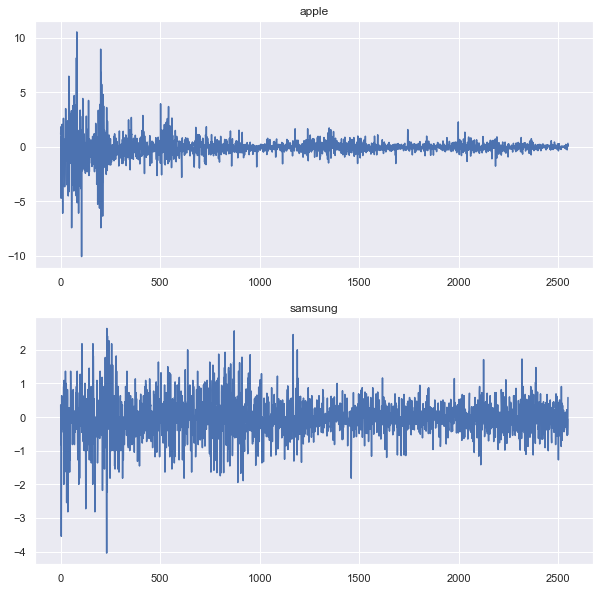

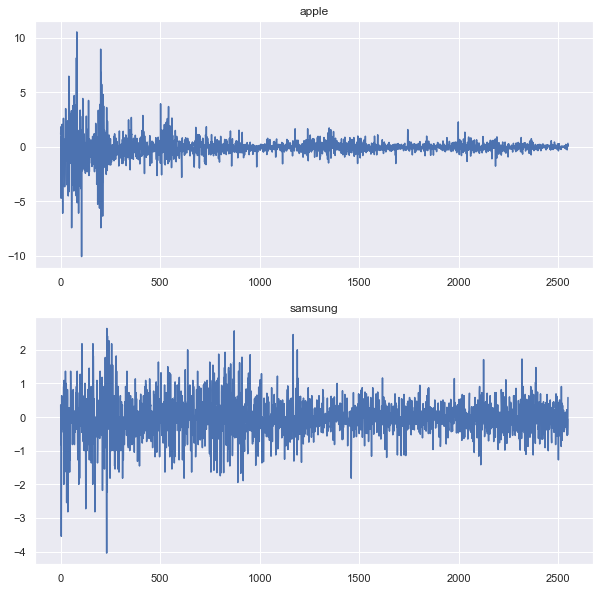

In [37]:
# 결과값 시각화 #
results.plot()

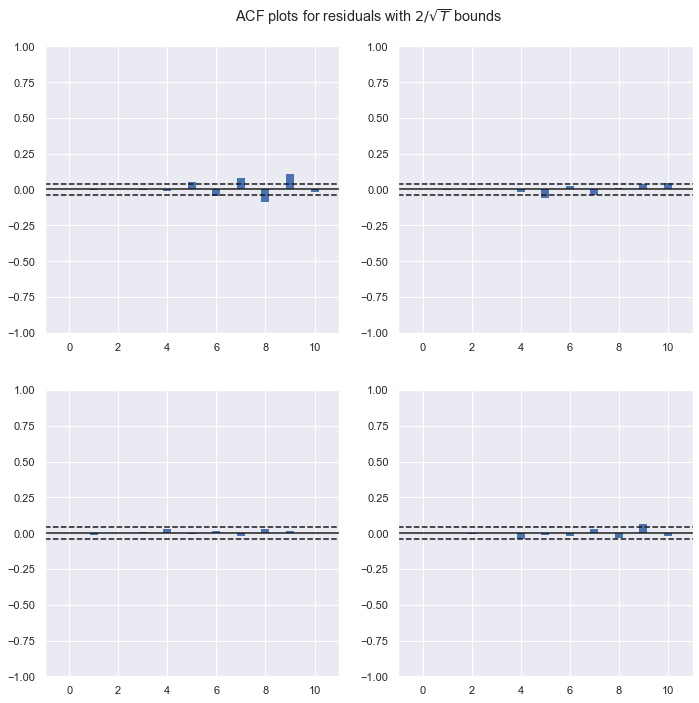

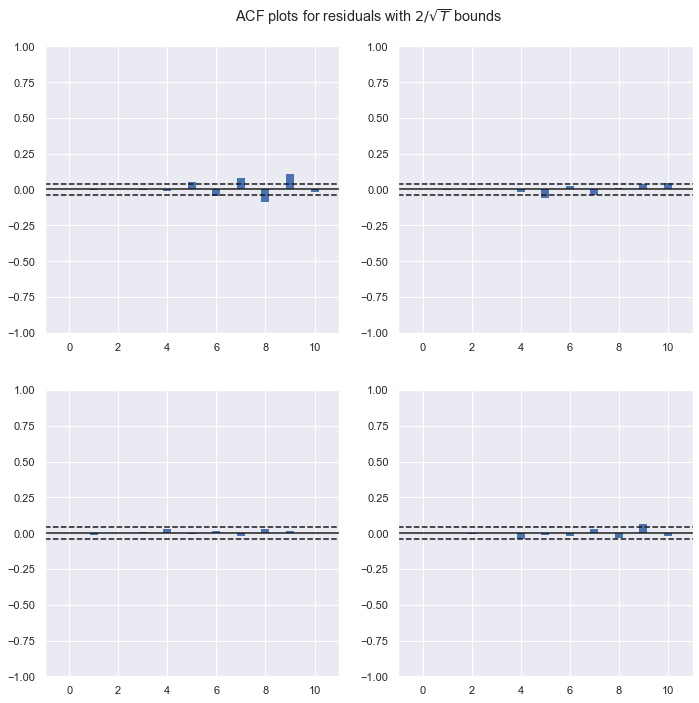

In [38]:
results.plot_acorr()

In [39]:
# 예측 (of 차분값)
laaged_values = train.values[-3:] #3은 p
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=20), index = test.index, columns= ['apple_1d', 'samsung_1d'])
forecast

,apple_1d,samsung_1d
DATE,,
2010-11-10,-0.019992,0.005565
2010-11-09,0.023184,0.011208
2010-11-08,-0.117923,-0.038449
2010-11-05,-0.039310,-0.022739
2010-11-04,-0.055727,-0.024294
2010-11-03,-0.043995,-0.021971
2010-11-02,-0.048342,-0.022085
2010-11-01,-0.047013,-0.021972
2010-10-29,-0.047670,-0.022032


In [42]:
# 예측 (of 실제값)
forecast["apple_forecasted"] = df["apple"].iloc[-20-1] + forecast['apple_1d'].cumsum()
forecast["samsung_forecasted"] = df["samsung"].iloc[-20-1] + forecast['samsung_1d'].cumsum() 
forecast

,apple_1d,samsung_1d,apple_forecasted,samsung_forecasted
DATE,,,,
2010-11-10,-0.019992,0.005565,11.290008,14.369202
2010-11-09,0.023184,0.011208,11.313191,14.380409
2010-11-08,-0.117923,-0.038449,11.195268,14.341960
2010-11-05,-0.039310,-0.022739,11.155958,14.319221
2010-11-04,-0.055727,-0.024294,11.100232,14.294927
2010-11-03,-0.043995,-0.021971,11.056236,14.272956
2010-11-02,-0.048342,-0.022085,11.007894,14.250871
2010-11-01,-0.047013,-0.021972,10.960882,14.228899
2010-10-29,-0.047670,-0.022032,10.913212,14.206867


<AxesSubplot:xlabel='DATE'>

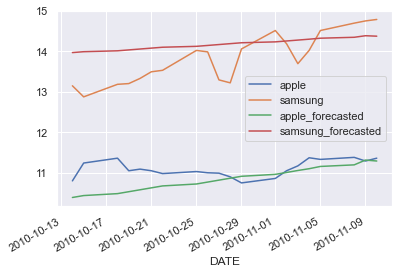

In [43]:
# 실제값과 시각화 비교 #
test = df.iloc[-20:,:]
test["apple_forecasted"] = forecast["apple_forecasted"]
test["samsung_forecasted"] = forecast["samsung_forecasted"]
test.plot()

## 6. 모델 평가 ##

In [51]:
test["samsung_errors"] = test["samsung_forecasted"] - test["samsung"]
test["apple_errors"] = test["apple_forecasted"] - test["apple"]
# mae
print("samsung mae : ", test["samsung_errors"].mean())
print("apple mae : ", test["apple_errors"].mean())

# mse
from sklearn.metrics import mean_squared_error
print("samsung mse : ", mean_squared_error(test["samsung"],test["samsung_forecasted"]))
print("apple mse : ", mean_squared_error(test["apple"],test["apple_forecasted"]))
      




samsung mae :  0.3524652039436518
apple mae :  -0.2574463826043026
samsung mse :  0.35938347964384665
apple mse :  0.13727791067001277


In [46]:
test

,apple,samsung,apple_forecasted,samsung_forecasted,samsung_errors,apple_errors
DATE,,,,,,
2010-11-10,11.36,14.781818,11.290008,14.369202,-0.412616,-0.069992
2010-11-09,11.29,14.745455,11.313191,14.380409,-0.365045,0.023191
2010-11-08,11.38,14.690909,11.195268,14.341960,-0.348949,-0.184732
2010-11-05,11.33,14.509091,11.155958,14.319221,-0.189870,-0.174042
2010-11-04,11.37,14.018182,11.100232,14.294927,0.276746,-0.269768
2010-11-03,11.17,13.690909,11.056236,14.272956,0.582047,-0.113764
2010-11-02,11.05,14.181818,11.007894,14.250871,0.069052,-0.042106
2010-11-01,10.86,14.509091,10.960882,14.228899,-0.280192,0.100882
2010-10-29,10.75,14.054545,10.913212,14.206867,0.152322,0.163212
